In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = 043bdfe
conc = None
dv = 0.001
klin = 4e-24
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

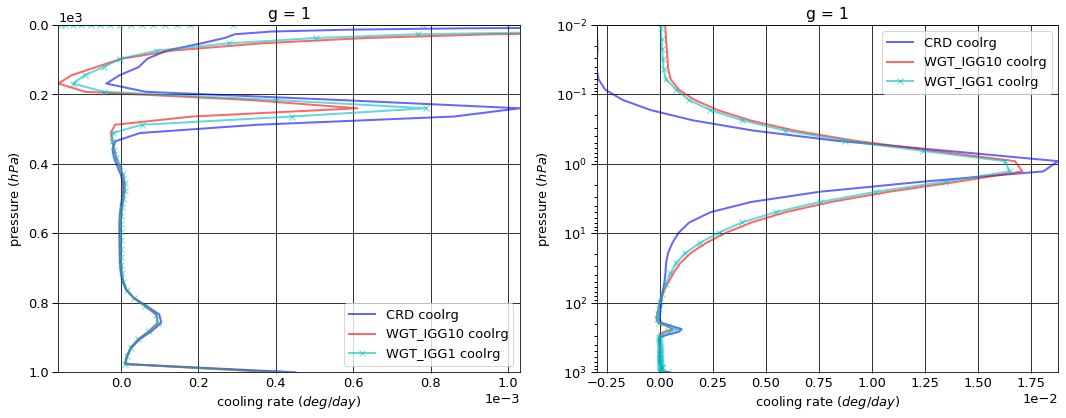

# Figure: cooling rate g-group 2

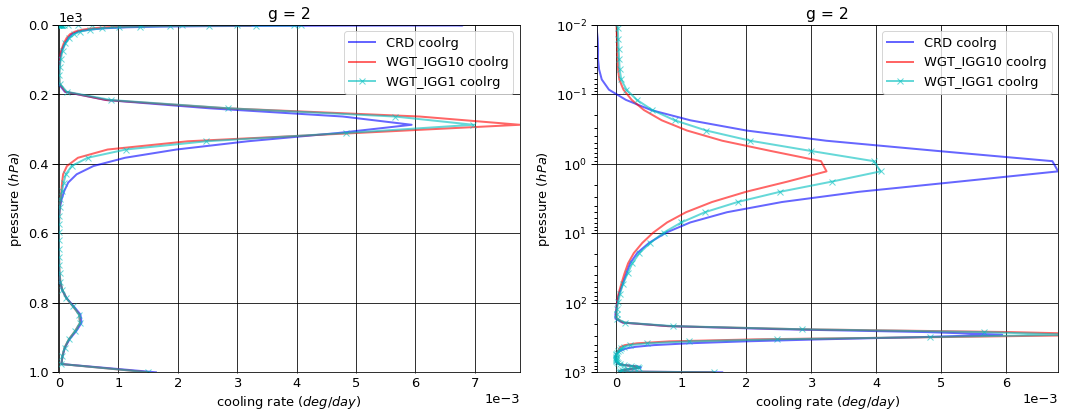

# Figure: cooling rate g-group 3

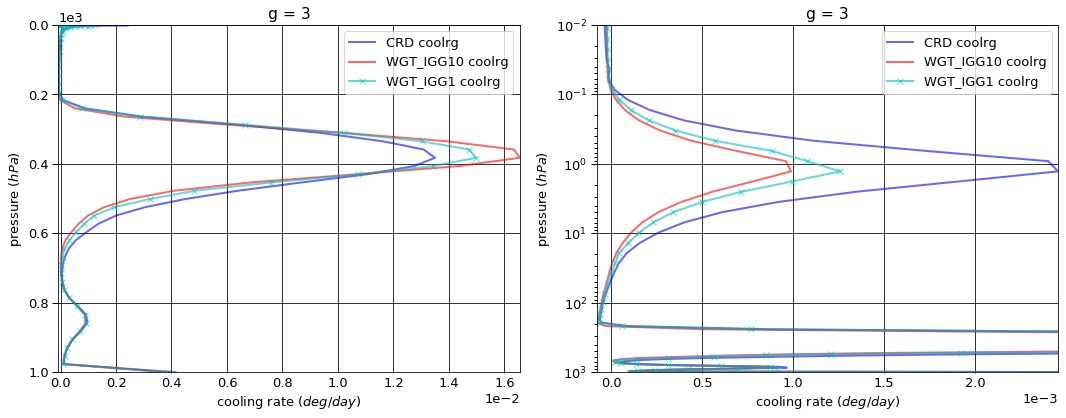

# Figure: cooling rate g-group 4

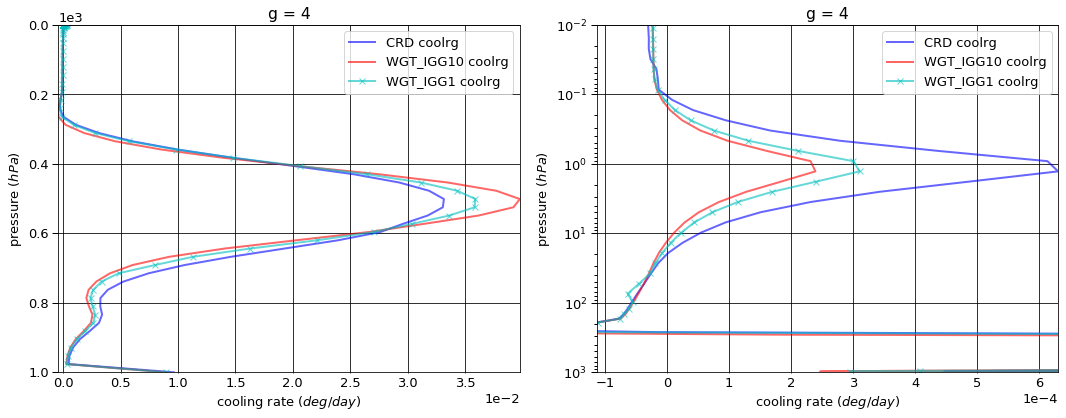

# Figure: cooling rate g-group 5

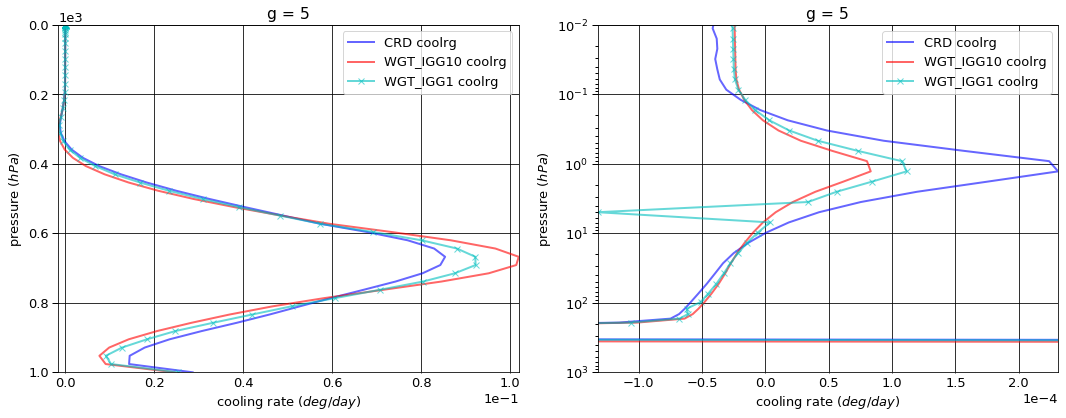

# Figure: cooling rate g-group 6

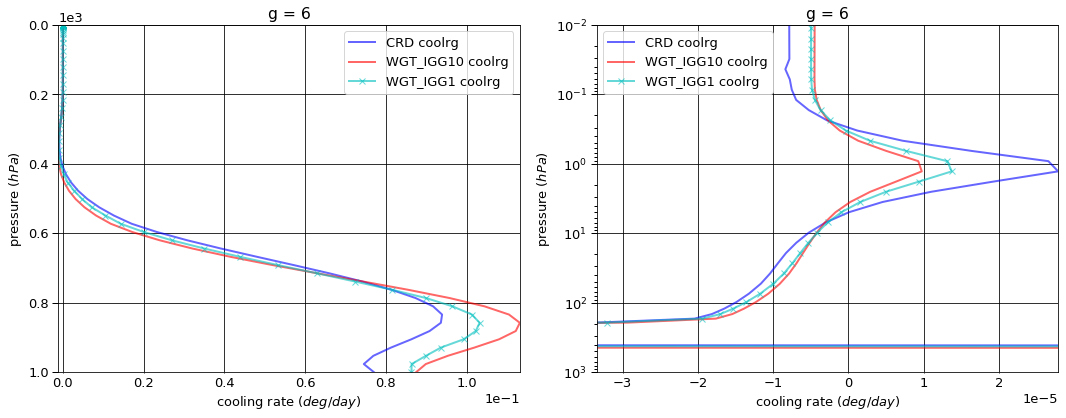

# Figure: cooling rate g-group 7

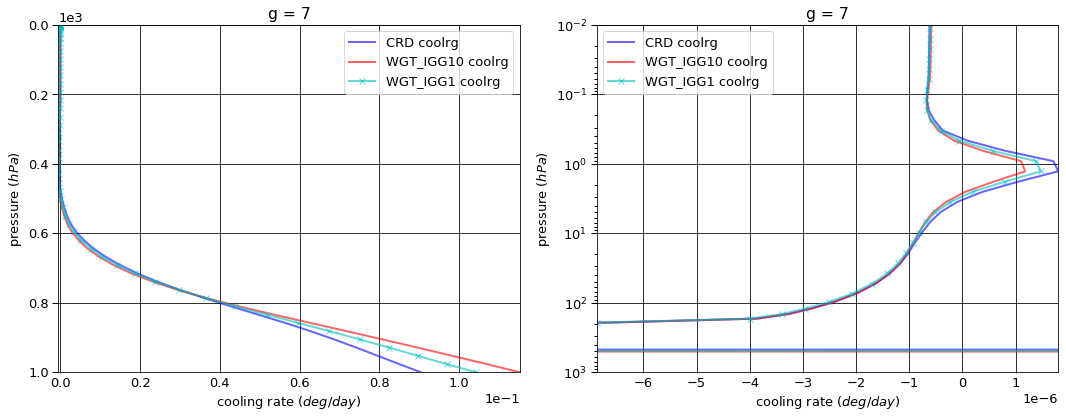

# Figure: cooling rate g-group total

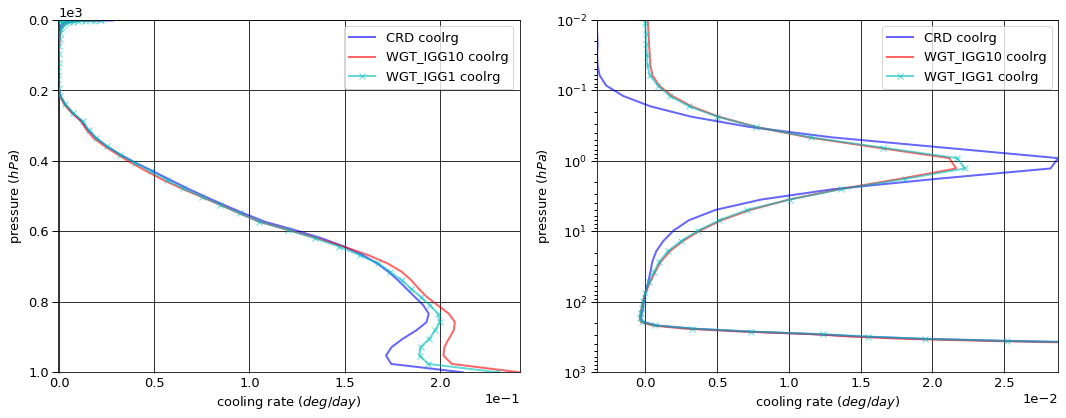

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019850  0.000000 -0.019850
  1013.0   76    -0.136273  0.135009 -0.001264
2 0.0      1     -0.092291  0.000000 -0.092291
  1013.0   76    -0.499190  0.494619 -0.004571
3 0.0      1     -0.346190  0.000000 -0.346190
  1013.0   76    -1.280001  1.268364 -0.011637
4 0.0      1     -1.178697  0.000000 -1.178697
  1013.0   76    -2.935864  2.908787 -0.027077
5 0.0      1     -3.459383  0.000000 -3.459383
  1013.0   76    -6.038941  5.926632 -0.112308
6 0.0      1     -4.636351  0.000000 -4.636351
  1013.0   76    -6.020298  5.101093 -0.919205
7 0.0      1     -6.375220  0.000000 -6.375220
  1013.0   76    -6.844609  2.627989 -4.216620


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019711  0.000000 -0.019711
  1013.0   76    -0.128239  0.127110 -0.001129
2 0.0      1     -0.089872  0.000000 -0.089872
  1013.0   76    -0.477066  0.472866 -0.004201
3 0.0      1     -0.338849  0.000000 -0.338849
  1013.0   76    -1.233735  1.222872 -0.010863
4 0.0      1     -1.154119  0.000000 -1.154119
  1013.0   76    -2.842312  2.817272 -0.025040
5 0.0      1     -3.419705  0.000000 -3.419705
  1013.0   76    -5.918066  5.837723 -0.080343
6 0.0      1     -4.744092  0.000000 -4.744092
  1013.0   76    -6.076653  5.364130 -0.712524
7 0.0      1     -6.587000  0.000000 -6.587000
  1013.0   76    -7.079104  2.933629 -4.145475


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.020051  0.000000 -0.020051
  1013.0   76    -0.128239  0.127110 -0.001129
2 0.0      1     -0.089973  0.000000 -0.089973
  1013.0   76    -0.477066  0.472866 -0.004201
3 0.0      1     -0.339007  0.000000 -0.339007
  1013.0   76    -1.233735  1.222872 -0.010863
4 0.0      1     -1.152950  0.000000 -1.152950
  1013.0   76    -2.842312  2.817258 -0.025055
5 0.0      1     -3.410286  0.000000 -3.410286
  1013.0   76    -5.918066  5.831418 -0.086648
6 0.0      1     -4.715272  0.000000 -4.715272
  1013.0   76    -6.076653  5.247378 -0.829276
7 0.0      1     -6.586590  0.000000 -6.586590
  1013.0   76    -7.079104  2.806598 -4.272506


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000139  0.000000  0.000139
  1013.0   76     0.008034 -0.007899  0.000135
2 0.0      1      0.002418  0.000000  0.002418
  1013.0   76     0.022124 -0.021754  0.000370
3 0.0      1      0.007341  0.000000  0.007341
  1013.0   76     0.046266 -0.045492  0.000774
4 0.0      1      0.024577  0.000000  0.024577
  1013.0   76     0.093552 -0.091515  0.002037
5 0.0      1      0.039678  0.000000  0.039678
  1013.0   76     0.120874 -0.088909  0.031965
6 0.0      1     -0.107740  0.000000 -0.107740
  1013.0   76    -0.056355  0.263037  0.206682
7 0.0      1     -0.211781  0.000000 -0.211781
  1013.0   76    -0.234494  0.305640  0.071146


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000201  0.000000 -0.000201
  1013.0   76     0.008034 -0.007899  0.000135
2 0.0      1      0.002318  0.000000  0.002318
  1013.0   76     0.022124 -0.021754  0.000370
3 0.0      1      0.007183  0.000000  0.007183
  1013.0   76     0.046266 -0.045492  0.000774
4 0.0      1      0.025746  0.000000  0.025746
  1013.0   76     0.093552 -0.091529  0.002022
5 0.0      1      0.049098  0.000000  0.049098
  1013.0   76     0.120874 -0.095214  0.025660
6 0.0      1     -0.078921  0.000000 -0.078921
  1013.0   76    -0.056355  0.146285  0.089930
7 0.0      1     -0.211371  0.000000 -0.211371
  1013.0   76    -0.234494  0.178609 -0.055885

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.134552e-03
  1001.112500 75     4.507992e-04
2 0.000312    1     -3.366954e-04
  1001.112500 75     1.630709e-03
3 0.000312    1     -4.954482e-05
  1001.112500 75     4.152486e-03
4 0.000312    1     -3.641773e-05
  1001.112500 75     9.625568e-03
5 0.000312    1     -4.231802e-05
  1001.112500 75     2.862246e-02
6 0.000312    1     -7.825040e-06
  1001.112500 75     7.707313e-02
7 0.000312    1     -5.900446e-07
  1001.112500 75     9.046936e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.840575e-05
  1001.112500 75     4.032614e-04
2 0.000312    1     -3.109018e-05
  1001.112500 75     1.500185e-03
3 0.000312    1     -2.987633e-05
  1001.112500 75     3.879610e-03
4 0.000312    1     -2.508233e-05
  1001.112500 75     8.944990e-03
5 0.000312    1     -2.552277e-05
  1001.112500 75     2.453623e-02
6 0.000312    1     -4.424452e-06
  1001.112500 75     8.745836e-02
7 0.000312    1     -5.535758e-07
  1001.112500 75     1.152753e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.548780e-04
  1001.112500 75     4.032614e-04
2 0.000312    1     -2.280101e-05
  1001.112500 75     1.500185e-03
3 0.000312    1     -2.963615e-05
  1001.112500 75     3.879610e-03
4 0.000312    1     -2.643901e-05
  1001.112500 75     8.972874e-03
5 0.000312    1     -2.760589e-05
  1001.112500 75     2.525901e-02
6 0.000312    1     -4.922514e-06
  1001.112500 75     8.633660e-02
7 0.000312    1     -5.772318e-07
  1001.112500 75     1.042478e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.172958e-03
  1001.112500 75    -4.753776e-05
2 0.000312    1      3.056052e-04
  1001.112500 75    -1.305237e-04
3 0.000312    1      1.966848e-05
  1001.112500 75    -2.728757e-04
4 0.000312    1      1.133539e-05
  1001.112500 75    -6.805776e-04
5 0.000312    1      1.679524e-05
  1001.112500 75    -4.086225e-03
6 0.000312    1      3.400588e-06
  1001.112500 75     1.038524e-02
7 0.000312    1      3.646876e-08
  1001.112500 75     2.480594e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.979674e-03
  1001.112500 75    -4.753776e-05
2 0.000312    1      3.138943e-04
  1001.112500 75    -1.305237e-04
3 0.000312    1      1.990867e-05
  1001.112500 75    -2.728757e-04
4 0.000312    1      9.978720e-06
  1001.112500 75    -6.526937e-04
5 0.000312    1      1.471213e-05
  1001.112500 75    -3.363452e-03
6 0.000312    1      2.902526e-06
  1001.112500 75     9.263477e-03
7 0.000312    1      1.281270e-08
  1001.112500 75     1.377839e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.107982,0.000000,-16.107982
1013.0,76,-23.755176,18.462493,-5.292683



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.353349,0.000000,-16.353349
1013.0,76,-23.755175,18.775601,-4.979574



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.314130,0.000000,-16.314130
1013.0,76,-23.755175,18.525499,-5.229677



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.453674e-01,0.000000,-0.245367
1013.0,76,1.300000e-07,0.313108,0.313108



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.061484e-01,0.000000,-0.206148
1013.0,76,1.300000e-07,0.063006,0.063006


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003608
1001.112500,75,0.212025



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000078
1001.112500,75,0.241998



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000267
1001.112500,75,0.230599



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003530
1001.112500,75,0.029973



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003341
1001.112500,75,0.018575


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.006842,0.005398
2,0.023964,0.020083
3,0.060036,0.051935
4,0.136030,0.119650
5,0.269400,0.249127
6,0.245121,0.255803
7,0.258606,0.298003


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.059275e-20
2,3.727310e-21
3,6.746469e-22
4,1.221118e-22
5,2.210236e-23
6,4.000550e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.059275e-20,NaN,0.006842,0.005398,0.006842,0.005398,600.0
2,3.727310e-21,0.181001,0.023964,0.020083,0.030806,0.025481,600.0
3,6.746469e-22,0.181001,0.060036,0.051935,0.090842,0.077416,600.0
4,1.221118e-22,0.181001,0.136030,0.119650,0.226873,0.197067,600.0
5,2.210236e-23,0.181001,0.269400,0.249127,0.496273,0.446194,600.0
6,4.000550e-24,0.181001,0.245121,0.255803,0.741394,0.701997,600.0
7,1.858499e-25,0.046456,0.258606,0.298003,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
